In [1]:
# path, venv, git bash terminal useful commands:
# cd C:/Users/marti/Desktop/AdventureWorks-msSQL-Python
# source .venv/Scripts/activate

# 1. Drivrutiner för Python och SQL connection.

In [2]:
import pyodbc
pyodbc.drivers()

['SQL Server',
 'ODBC Driver 18 for SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']

# 2. Definierad Python och SQL connection samt funktion.

In [3]:
import pandas as pd
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

# quote_plus motverkar UTF-8 issues i connection.

user = "SA"
password = quote_plus(input(""))
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

In [4]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

In [5]:
query_test = """
SELECT TOP 5 *
FROM Person.person
"""

query_test_df = query_df(query_test)
query_test_df.head()

C:\Users\marti\AppData\Local\Temp\ipykernel_22008\4012941776.py:2: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect() as conn:


,BusinessEntityID,PersonType,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,EmailPromotion,AdditionalContactInfo,Demographics,rowguid,ModifiedDate
0,1,EM,False,None,Ken,J,Sánchez,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",92C4279F-1207-48A3-8448-4636514EB7E2,2020-01-07
1,2,EM,False,None,Terri,Lee,Duffy,None,1,None,"<IndividualSurvey xmlns=""http://schemas.micros...",D8763459-8AA8-47CC-AFF7-C9079AF79033,2019-01-23
2,3,EM,False,None,Roberto,None,Tamburello,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",E1A2555E-0828-434B-A33B-6F38136A37DE,2018-11-03
3,4,EM,False,None,Rob,None,Walters,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",F2D7CE06-38B3-4357-805B-F4B6B71C01FF,2018-11-27
4,5,EM,False,Ms.,Gail,A,Erickson,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",F3A3F6B4-AE3B-430C-A754-9F2231BA6FEF,2018-12-29


# 3. Genomgång av Uppgifter för AdventureWorks2025 db.

## 3.1 Uppgift 1:

**Antal produkter per kategori.**

In [6]:
query_1 = """
SELECT ISNULL(ppc.Name, 'Okategoriserad') AS Kategori, 
            COUNT(pp.ProductID) AS AntalProdukter 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
GROUP BY ppc.Name ORDER BY AntalProdukter DESC;"""

query_1_df = query_df(query_1) 
query_1_df

,Kategori,AntalProdukter
0,Okategoriserad,209
1,Components,134
2,Bikes,97
3,Clothing,35
4,Accessories,29


Eftersom Person.Person.ProductID är en primär nyckel med inkrement, behövs inte DISTINCT inom COUNT(pp.ProductID). COUNT-beräkningen är en aggregerad funktion som är möjliggjord via GROUP BY utav kategorinamnen. Alltså räknar count alla närvarande produkt-id i queryn och visar hur många produkter som finns per kategori.

Tack vare LEFT JOIN, med Production.Product tabellen på vänster sida, räknar `query 1` rader (produkter) som saknar ProductSubcategoryID såväl som produkter som är kategoriserade. En INNER JOIN skulle missat okategoriserade rader.

Visualisering:

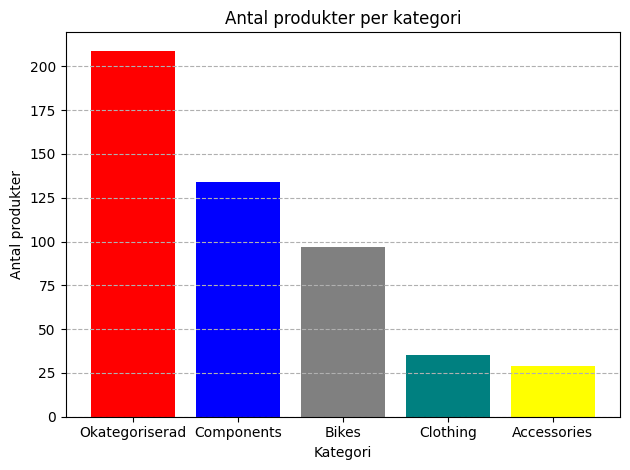


Kategori med flest produkter:
Kategori          Components
AntalProdukter           134
dtype: object

Kategori med minst produkter:
Kategori          Accessories
AntalProdukter             29
dtype: object


In [7]:
import matplotlib.pyplot as plt
colors = ['red', 'blue', 'grey', 'teal', 'yellow']
plt.bar(query_1_df.Kategori, query_1_df['AntalProdukter'], color=colors) 
plt.title("Antal produkter per kategori") 
plt.xlabel("Kategori") 
plt.ylabel("Antal produkter") 
plt.grid(True, axis='y', linestyle="--") 
plt.tight_layout() 
plt.show()

# Printa flest & minst produkter
# Sortera ut okategoriserade produkter
query_1_df_mod = query_1_df.iloc[1:,:] 
print("\nKategori med flest produkter:") 
print(query_1_df_mod.max())
print("\nKategori med minst produkter:") 
print(query_1_df_mod.min()) 

Ovan är en graf, följt av en förklaring av kategorier med flest och minst produkter.

Vid önskan om att inspektera okategoriserade produkter, körs en LEFT JOIN & WHERE IS NULL query:

In [8]:
query_1_bonus = """ 
SELECT pp.ProductID AS ProduktID, 
            pp.Name AS ProduktNamn, 
            pp.ProductSubcategoryID AS SubkategoriID, 
            pps.Name AS SubkategoriNamn, 
            ppc.Name AS KategoriNamn 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
WHERE pp.ProductSubcategoryID IS NULL 
ORDER BY pp.ProductID;"""

query_1_bonus_df = query_df(query_1_bonus) 
query_1_bonus_df.tail(3)   # titta på sista 3 raderna

,ProduktID,ProduktNamn,SubkategoriID,SubkategoriNamn,KategoriNamn
206,534,Top Tube,None,None,None
207,535,Tension Pulley,None,None,None
208,679,Rear Derailleur Cage,None,None,None


Längden på resulterande tabell verkar stämma mot grafens stapel Okategoriserad.

Vidare granskning berör frekvens av kategorier med aktiva produkter. 


In [9]:
query_1_active = """ 
SELECT ISNULL(ppc.Name, 'Okategoriserad') AS Kategori, 
        COUNT(pp.ProductID) AS AntalProdukter 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
WHERE pp.SellEndDate IS NULL GROUP BY ppc.Name 
ORDER BY AntalProdukter DESC; """

query_1_active_df = query_df(query_1_active) 
diff = query_1_df.AntalProdukter - query_1_active_df.AntalProdukter 
query_1_active_copy = query_1_active_df.copy() 
query_1_active_copy['Differens'] = diff 
query_1_active_copy['HistoriskaOchAktivaProdukter'] = query_1_df.AntalProdukter 
query_1_active_copy

,Kategori,AntalProdukter,Differens,HistoriskaOchAktivaProdukter
0,Okategoriserad,209,0,209
1,Components,95,39,134
2,Bikes,60,37,97
3,Accessories,22,13,35
4,Clothing,20,9,29


I resulterande tabell med tillagd kolumn Differens via python-kod (visar antalet inaktiva produkter), som givetvis skulle gå att ta fram via SQL query också, ser vi att inaktiva produkter inom Components är 39st, och så vidare. Alltså är potentiellt WHERE pp.SellEndDate IS NULL ett välbehövligt filter för query 1 ifall inaktiva produkter ska borträknas i kategoriuppdelningen.

## 3.2 Uppgift 2:

**Vilka produktkategorier genererar mest intäkter?**

In [10]:
query_2 = """ 
SELECT ppc.Name AS Kategori, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.ProductCategory AS ppc 
INNER JOIN Production.ProductSubcategory AS pps 
    ON ppc.ProductCategoryID = pps.ProductCategoryID 
INNER JOIN Production.Product AS pp 
    ON pps.ProductSubcategoryID = pp.ProductSubcategoryID 
INNER JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
GROUP BY ppc.Name 
ORDER BY TotalFörsäljning DESC; """

query_2_df = query_df(query_2) 
query_2_df

,Kategori,TotalFörsäljning
0,Bikes,9.465117e+07
1,Components,1.180259e+07
2,Clothing,2.120543e+06
3,Accessories,1.272073e+06


Med INNER JOIN visas här nu bara data ifall försäljning har ägt rum inom SalesOrderDetail, vilket är logiskt mot affärsfrågan. Även använder vi SUM av LineTotal i SalesOrderDetail, som följer matematiska logiken $$LineTotal = UnitPrice * (1 - Discount) * Quantity.$$ Vid första anblick ser cyklar ut att driva högst intäkter.

En query med LEFT JOIN låter oss se okategoriserade produkter som har sett försäljning, för att inte missa intäkter i våra beräkningar (även om dessa kan väljas att bortses ifrån). 

In [11]:
query_2_left = """ 
SELECT pp.ProductID AS ProduktID, 
        pp.Name AS ProduktNamn, 
        pps.Name AS SubkategoriNamn, 
        ppc.Name AS KategoriNamn, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
LEFT JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
GROUP BY ppc.Name, pps.Name, pp.Name, pp.ProductID 
ORDER BY TotalFörsäljning DESC; """

query_2_left_df = query_df(query_2_left) 
display(query_2_left_df.tail(3)) # titta på sista 3 raderna

,ProduktID,ProduktNamn,SubkategoriNamn,KategoriNamn,TotalFörsäljning
501,679,Rear Derailleur Cage,None,None,NaN
502,680,"HL Road Frame - Black, 58",Road Frames,Components,NaN
503,706,"HL Road Frame - Red, 58",Road Frames,Components,NaN


In [12]:
# python overview av query_2_left_df
print("Här är hur många rader som saknar kategori men ändå haft försäljning: ", len(
    query_2_left_df[(query_2_left_df['KategoriNamn'].isna()) & 
                    (query_2_left_df['TotalFörsäljning'] > 0)])) # blir noll 

Här är hur många rader som saknar kategori men ändå haft försäljning:  0


Eftersom alla okategoriserade produkter har NaN i TotalFörsäljning, är slutsatsen att INNER JOIN räcker för intäktsanalysen. Okategoriserade produkter kan härstamma som prototyper, icke-lanserade, reservdelar eller produkter som används inuti företaget.

Vi gör en förfinad tabell beaktandes kategoriserade produkter, som även beräknar värden för nuvarande aktiva produkter och differens mot inklusive inaktiva produkters försäljning, alltså inräknad historik. 

In [13]:
query_2_active = """ 
SELECT ppc.Name AS Kategori, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.ProductCategory AS ppc 
INNER JOIN Production.ProductSubcategory AS pps 
    ON ppc.ProductCategoryID = pps.ProductCategoryID 
INNER JOIN Production.Product AS pp 
    ON pps.ProductSubcategoryID = pp.ProductSubcategoryID 
INNER JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
WHERE pp.SellEndDate IS NULL 
GROUP BY ppc.Name
ORDER BY TotalFörsäljning DESC;"""

query_2_active_df = query_df(query_2_active)
diff = query_2_df.TotalFörsäljning - query_2_active_df.TotalFörsäljning 
query_2_active_copy = query_2_active_df.copy() 
query_2_active_copy['Differens'] = diff.round(0).astype(int) 
query_2_active_copy['HistoriskFörsäljning'] = query_2_df.TotalFörsäljning.round(0).astype(int) 
query_2_active_copy['TotalFörsäljning'] = query_2_active_copy['TotalFörsäljning'].round(0).astype(int)

print("Här är en presentationsvänlig tabell på försäljning per kategori:") 
display(query_2_active_copy) 

Här är en presentationsvänlig tabell på försäljning per kategori:


,Kategori,TotalFörsäljning,Differens,HistoriskFörsäljning
0,Bikes,61069197,33581976,94651173
1,Components,9468393,2334200,11802593
2,Clothing,1531721,588821,2120543
3,Accessories,1242318,29755,1272073


Exakta siffrorna för högst respektive lägst försäljning, som tillfaller kategorin cyklar och accessoarer (oavsett aktivitetsfiltret):

In [14]:
print(f"""Högst försäljning: {query_2_df.TotalFörsäljning[0]},
Och för aktiva produkter: {query_2_active_df.TotalFörsäljning[0]}""")
print("-----------------------------------------")
print(f"""Lägst försäljning: {query_2_df.TotalFörsäljning[len(query_2_df)-1]},
Och för aktiva produkter: {query_2_active_df.TotalFörsäljning[len(query_2_active_df)-1]}""") 
# len() för att ta sista indexplatsen, alltså lägsta siffran.

Högst försäljning: 94651172.704731,
Och för aktiva produkter: 61069196.787288
-----------------------------------------
Lägst försäljning: 1272072.883926,
Och för aktiva produkter: 1242317.97665


Visualisering som beaktar historiska totala-, och aktiva produkters totala försäljning:

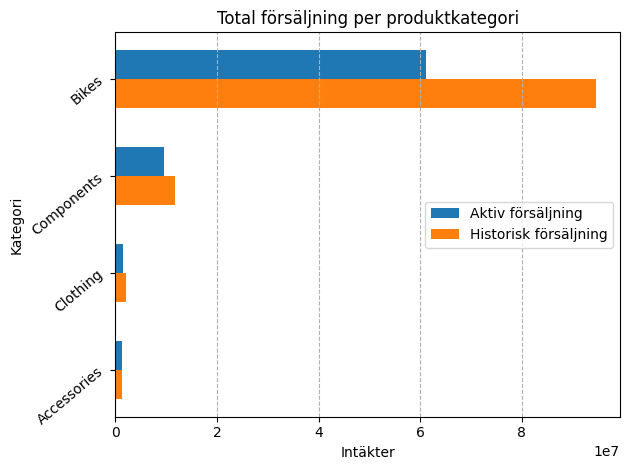

In [15]:
import numpy as np

cols = ['TotalFörsäljning','HistoriskFörsäljning'] # behöver sortera som stigande, för barh plot ska ha högst överst.
ascending_df = query_2_active_copy.copy().sort_values(by=cols, ascending=True) # använder den förfinade tabellen
categories = ascending_df['Kategori'] # plockar ut kolumner som ska plottas till variabler
active_sales = ascending_df['TotalFörsäljning']
historic_sales = ascending_df['HistoriskFörsäljning']
length = len(ascending_df) # hur många staplar ska plottas
y = np.arange(length) 
width = 0.3

plt.figure()
plt.barh(y + width/2, active_sales, width, label='Aktiv försäljning')
plt.barh(y - width/2, historic_sales, width, label='Historisk försäljning')

plt.yticks(y, categories, rotation=40)
plt.ylabel('Kategori')
plt.xlabel('Intäkter')
plt.title("Total försäljning per produktkategori")
plt.legend(loc='center right')
plt.grid(True, axis='x', linestyle="--")
plt.tight_layout()
plt.show()

Affärsinsikt:

Kategorier med högst intäkter är beroende av produkternas vinstmarginaler eller omsättningsfigurer, som tycks gås igenom i uppgift 5 (top 10 produkter), samtidigt som kostnadsstruktur är viktig för sådan analys. Cyklar är dyra vilket driver på den figuren som är högst.

Fråga 2 berör intäkter: volym och prisnivå, och inte ens över tid, vilket uppgift 3 & 4 tycks handla om. Geografisk försäljning syns till i uppgift 7.

## 3.3 Uppgift 3:

**Försäljningstrend över tid.**

In [16]:
# Inspektera SalesOrderHeader:
q3 = """
SELECT TOP 3 *
FROM Sales.SalesOrderHeader"""

q3_df = query_df(q3)
display(q3_df)
print("---------------------------------------------\nAlla kolumner: ")
# printa kolumnerna
for col in q3_df.columns:
    print(" ", col, end="")

,SalesOrderID,RevisionNumber,OrderDate,DueDate,ShipDate,Status,OnlineOrderFlag,SalesOrderNumber,PurchaseOrderNumber,AccountNumber,...,CreditCardID,CreditCardApprovalCode,CurrencyRateID,SubTotal,TaxAmt,Freight,TotalDue,Comment,rowguid,ModifiedDate
0,43659,10,2022-05-30,2022-06-11,2022-06-06,5,False,SO43659,PO522145787,10-4020-000676,...,16281,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2022-06-06
1,43660,10,2022-05-30,2022-06-11,2022-06-06,5,False,SO43660,PO18850127500,10-4020-000117,...,5618,115213Vi29411,NaN,1294.2529,124.2483,38.8276,1457.3288,None,738DC42D-D03B-48A1-9822-F95A67EA7389,2022-06-06
2,43661,10,2022-05-30,2022-06-11,2022-06-06,5,False,SO43661,PO18473189620,10-4020-000442,...,1346,85274Vi6854,4.0,32726.4786,3153.7696,985.5530,36865.8012,None,D91B9131-18A4-4A11-BC3A-90B6F53E9D74,2022-06-06


---------------------------------------------
Alla kolumner: 
  SalesOrderID  RevisionNumber  OrderDate  DueDate  ShipDate  Status  OnlineOrderFlag  SalesOrderNumber  PurchaseOrderNumber  AccountNumber  CustomerID  SalesPersonID  TerritoryID  BillToAddressID  ShipToAddressID  ShipMethodID  CreditCardID  CreditCardApprovalCode  CurrencyRateID  SubTotal  TaxAmt  Freight  TotalDue  Comment  rowguid  ModifiedDate

Efter granskning av kolumner och lite rad-data verkar inga JOINs vara aktuella, då vi har datum och siffror såsom totalkostnad inklusive moms per order i denna tabellen.

Vi specificerar SELECT med önskade kolumner:

In [17]:
query_3 = """
SELECT OrderDate,
        TotalDue
FROM Sales.SalesOrderHeader
"""

query_3_df = query_df(query_3)
display(query_3_df.tail(4))
display(query_3_df.info()) # inga rader är NaN.

,OrderDate,TotalDue
31461,2025-06-29,93.8808
31462,2025-06-29,82.8529
31463,2025-06-29,34.2219
31464,2025-06-29,209.9169


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31465 entries, 0 to 31464
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   OrderDate  31465 non-null  datetime64[ns]
 1   TotalDue   31465 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 491.8 KB


None

In [18]:
print(query_3_df.OrderDate.min()) # kika på tidigaste och senaste datum.
print(query_3_df.OrderDate.max())

2022-05-30 00:00:00
2025-06-29 00:00:00


Ordrarna verkar vara i datum stigande ordning, och vi håller oss till analys som bortser från frakt, skatt och omkostnad exklusive moms. Förvisso kan det aggregeras siffror för sådana mätvärden över tidsperioden, medan analysen blir troligtvis tillräcklig utan att gå in på de detaljerna. 

Aggregerar totalomkostnad av ordrar per månad via query:

In [19]:
query_3_agg = """
SELECT FORMAT(OrderDate, 'yyyy-MM') AS Månad,
        SUM(TotalDue) TotalFörsäljning
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY Månad"""

query_3_agg_df = query_df(query_3_agg)
query_3_agg_df.tail(4)

,Månad,TotalFörsäljning
34,2025-03,5.585676e+06
35,2025-04,5.847165e+06
36,2025-05,2.108406e+06
37,2025-06,5.247819e+04


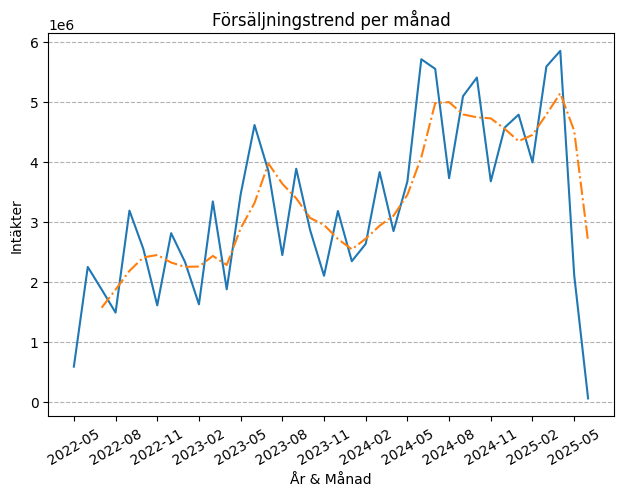


---------------------------------------------------------------------------
Högsta försäljningssiffran och aktuell månad: 5847164.7, 2025-04

Lägsta försäljningssiffran och aktuell månad: 52478.2, 2025-06



In [20]:
plt.figure()
plt.plot(query_3_agg_df.Månad, query_3_agg_df.TotalFörsäljning)
plt.title("Försäljningstrend per månad")
plt.xlabel("År & Månad")
plt.ylabel("Intäkter")
plt.tight_layout()
plt.grid(True, axis='y', linestyle="--")
plt.xticks(query_3_agg_df.Månad[::3], rotation=30)
plt.plot(query_3_agg_df.Månad, query_3_agg_df.TotalFörsäljning.rolling(3).mean(), label="Glidande medelvärde",
         linestyle="-.")
plt.show()

print("\n---------------------------------------------------------------------------")
max_sales = query_3_agg_df.loc[query_3_agg_df.TotalFörsäljning.idxmax()]
min_sales = query_3_agg_df.loc[query_3_agg_df.TotalFörsäljning.idxmin()]
print(f"Högsta försäljningssiffran och aktuell månad: {max_sales.TotalFörsäljning.round(1)}, {max_sales.Månad}\n")
print(f"Lägsta försäljningssiffran och aktuell månad: {min_sales.TotalFörsäljning.round(1)}, {min_sales.Månad}\n")

Ovan är en graf med månadsvis aggregering av försäljningssiffrorna, inklusive historiska och aktiva produkter.

Ett glidande medelvärde med 3 månader lagg låter oss se trendutvecklingen, som annars också skulle kunna fås fram genom att aggregera flera månader till samma datapunkt med medelvärden av intäkterna.

En strikt linje från början av grafen, till slutet (innan det dramatiska fallet som påbörjas efter maximum vid 2025-04) skulle visa en stadigt stigande trend.

De två andra vassa topparna, förutom den sista längst till höger, skedde under månad 5 och 6 under de åren, så visst säsongsmönster finns fastän de flesta dalar är lite oregelbundna det vill säga inte jämnt ökande med intäktsökningen.

Att den månadsvisa aggeregerade grafen är volatil öppnar ändå för frågan om försäljningssiffrorna är säsongsberoende.

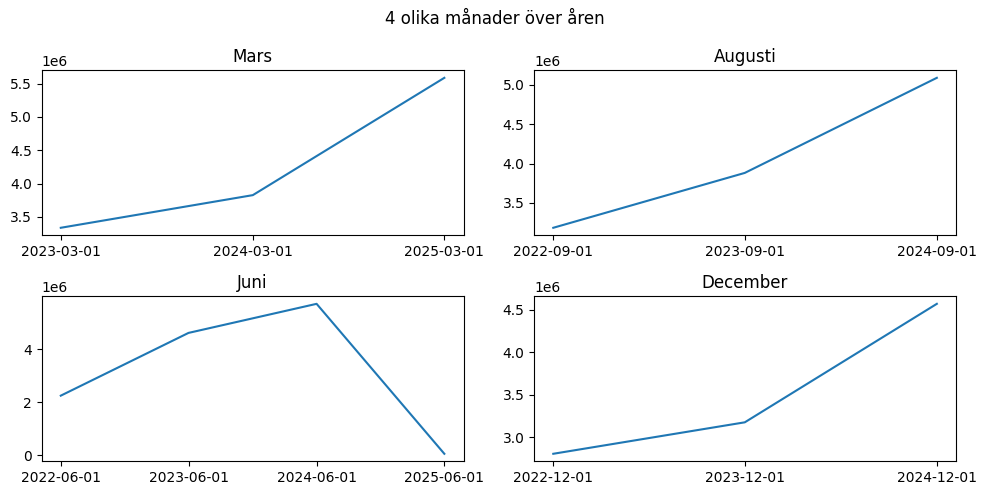

In [21]:
query_3_agg_df.Månad = pd.to_datetime(query_3_agg_df.Månad)
query_3_agg_df['MånadNummer'] = query_3_agg_df.Månad.dt.month

mars = query_3_agg_df[query_3_agg_df.MånadNummer == 3 ] # här kan man lägga till -1, eller -2, så ser man andra månader.
juni = query_3_agg_df[query_3_agg_df.MånadNummer == 6 ]
aug = query_3_agg_df[query_3_agg_df.MånadNummer ==  9 ]
dec = query_3_agg_df[query_3_agg_df.MånadNummer ==  12]

fig, axes = plt.subplots(2,2, figsize=(10,5))
plt.suptitle("4 olika månader över åren")
axes[0,0].plot(mars.Månad, mars.TotalFörsäljning)
axes[0,0].set_xticks(mars.Månad)
axes[0,0].set_title("Mars")

axes[1,0].plot(juni.Månad, juni.TotalFörsäljning)
axes[1,0].set_xticks(juni.Månad)
axes[1,0].set_title("Juni")

axes[0,1].plot(aug.Månad, aug.TotalFörsäljning)
axes[0,1].set_xticks(aug.Månad)
axes[0,1].set_title("Augusti")

axes[1,1].plot(dec.Månad, dec.TotalFörsäljning)
axes[1,1].set_xticks(dec.Månad)
axes[1,1].set_title("December")

plt.tight_layout()
# plt.show()

Med kodcellen ovan kan man testa årets 12 månader, 3 månader emellan i graferna. Det finns 3, ibland 4, år med historisk data för månaderna, som kanske inte räcker för att säkerställa att försäljningen är säsongsbunden. Till detta så noteras även att ingen månad hade konsekvent förhöjda intäkter återkommande, vilket dock kan otydliggöras med vetskapen att intäkterna har ökat från start till nästan slutet på datasetet. Andra aggregeringar, såsom ifall två till fyra månader skulle slås samman, skulle kanske visuellt samband kunna framstå. Det djupet på analysen är bortom denna studiens omfång. 

## 3.4 Uppgift 4:

**Hur ser total försäljning och antal ordrar ut per år?**

In [22]:
q4 = """
SELECT YEAR(OrderDate) AS År,
        CAST(ROUND(SUM(TotalDue),0) AS INT) TotalFörsäljning,
        COUNT(*) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY År
"""

q4_df = query_df(q4)
q4_df

,År,TotalFörsäljning,AntalOrdrar
0,2022,16316694,1692
1,2023,35514706,3830
2,2024,49020487,14244
3,2025,22364900,11699


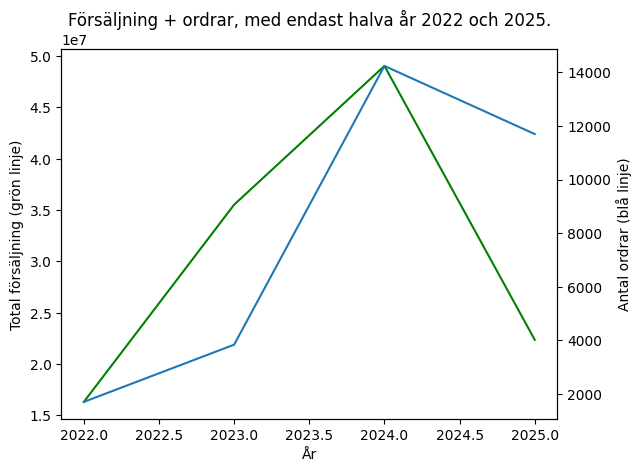

In [23]:
# Python kan plotta q4_df.

fig, ax = plt.subplots()
ax.plot(q4_df.År, q4_df.TotalFörsäljning, color="green")
ax.set_xlabel("År")
ax.set_ylabel("Total försäljning (grön linje)")

ax2 = ax.twinx() # sekundär y-axel, då ordrar är i tiotusen och försäljning på tiotals miljoner.
ax2.plot(q4_df.År, q4_df.AntalOrdrar)
ax2.set_ylabel("Antal ordrar (blå linje)")

plt.title("Försäljning + ordrar, med endast halva år 2022 och 2025.")
plt.show()

Ovan är en sammanställning av årens försäljning (grön linje) och antal ordrar (blå linje), notera att första och sista året är endast halvår med försäljning. För att simulera kompletta försäljningsår skulle det kanske gå att dubblera värdena på första och sista raden. Vid snabb granskning verkar siffrorna vara stadigt stigande på det sättet, fastän försäljningen var avvikande låg mot slutet av tiden. Alternativt skulle beräkningar gå att göra såsom att låta juni 2022 till juni 2023 räknas som första året, och så vidare. På så vis skulle man räkna hela år, vilket också skulle ha en ökande försäljningstrend medan en skarp dipp äger rum mot slutet av tiden. I praktiken går det att dela in datum-grupperad försäljning på 3 hela år då starten är maj 2022 till juni 2025. Dessa anmärkningar är bra att känna till för att kunna analysera datasetet korrekt.

En linjegraf av försäljningsdata med anpassad aggregering såväl som tabellen ovan som alltså har 2st halvår (första och sista raderna), kanske framhäver tydligare trender för att komplettera trendmönster-diskussionen i *uppgift 3*, och visualisera effekten av halvårs-räknade finansiella år.

In [24]:
# Återkalla tidigare query, som ger 38st månader med data.
# lägger till AntalOrdrar.
query_3_agg = """
SELECT FORMAT(OrderDate, 'yyyy-MM') AS Månad,
        SUM(TotalDue) TotalFörsäljning,
        COUNT(*) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY Månad"""

query_3_agg_df = query_df(query_3_agg)
query_3_agg_df.Månad = pd.to_datetime(query_3_agg_df.Månad)
query_3_agg_df['MånadNummer'] = query_3_agg_df.Månad.dt.month
query_3_agg_df.head(2)

,Månad,TotalFörsäljning,AntalOrdrar,MånadNummer
0,2022-05-01,5.824153e+05,47,5
1,2022-06-01,2.244313e+06,217,6


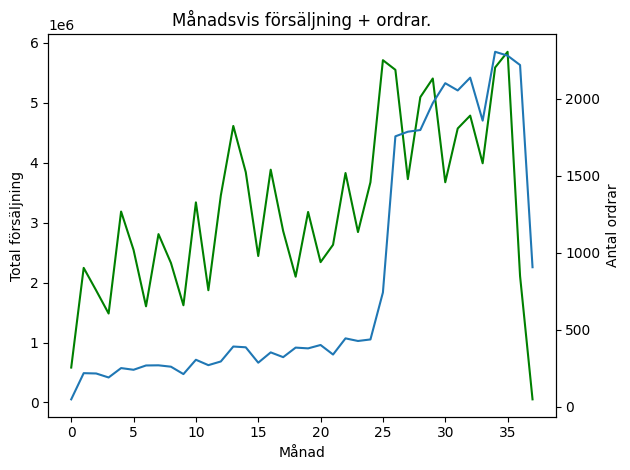

In [25]:
# Här är samma graf som i uppgift 3, men med ordrar per månad inlagda.
x = range(len(query_3_agg_df)) # fixa månadnummer på x axeln

fig, ax = plt.subplots()
ax.plot(x, query_3_agg_df["TotalFörsäljning"], color='green')
ax.set_xlabel("Månad")
ax.set_ylabel("Total försäljning")

ax2 = ax.twinx() # sekundär y-axel
ax2.plot(x, query_3_agg_df["AntalOrdrar"])
ax2.set_ylabel("Antal ordrar")

plt.title("Månadsvis försäljning + ordrar.")
plt.tight_layout()

I denna grafen syns till vänster att antal ordrar inte behöver driva försäljningskurvan, samtidigt som på våren 2024 ökar ordrar och försäljning och även slutet av datasettet faller både försäljning och antalet ordrar. Detta tillhör inte helårs-analysen av denna uppgiften men skiner ändå ljus på intressant dynamik.

Nu fortsätter vi därmed med att plotta hela *anpassade* finansiella år, utan att ha två halvår som vid start och slut av datasetet ska räknas in som egna finansiella år.

In [26]:
# Python kan gruppera query_3_agg med ordrar, över anpassade helår.

query_3_agg_df["AnpassatÅr"] = query_3_agg_df["Månad"].apply(lambda x: x.year if x.month >= 5 else x.year - 1)
adapt_year_df = (query_3_agg_df.groupby("AnpassatÅr")[["TotalFörsäljning", "AntalOrdrar"]].sum().reset_index())

adapt_year_df

,AnpassatÅr,TotalFörsäljning,AntalOrdrar
0,2022,2.547136e+07,2735
1,2023,3.799706e+07,4394
2,2024,5.758749e+07,21213
3,2025,2.160884e+06,3123


In [27]:
# Med troligen samma resultat kan SQL query med CASE ge oss:
q5 = """
SELECT
    CASE
        WHEN MONTH(OrderDate) >= 5 THEN YEAR(OrderDate)
        ELSE YEAR(OrderDate) - 1
    END AS AnpassatÅr,
    SUM(TotalDue) AS TotalFörsäljning,
    COUNT(*) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY 
    CASE 
        WHEN MONTH(OrderDate) >= 5 THEN YEAR(OrderDate)
        ELSE YEAR(OrderDate) - 1
    END
ORDER BY AnpassatÅr"""
q5_df = query_df(q5)
q5_df

,AnpassatÅr,TotalFörsäljning,AntalOrdrar
0,2022,2.547136e+07,2735
1,2023,3.799706e+07,4394
2,2024,5.758749e+07,21213
3,2025,2.160884e+06,3123


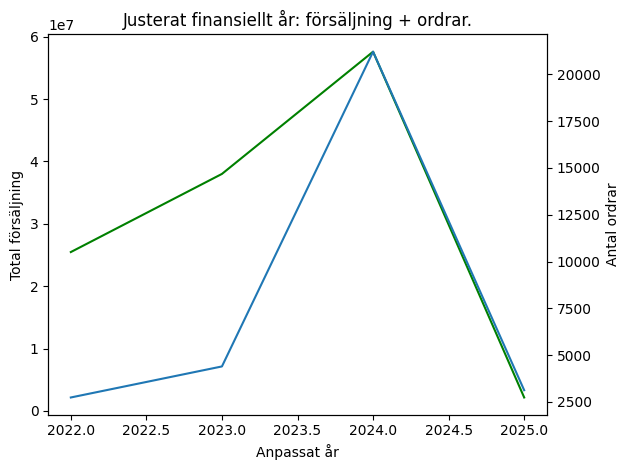

In [28]:
# Tabellerna ovan stämde överens, så både python och sql kan framkalla anpassad data.

fig, ax = plt.subplots()

ax.plot(adapt_year_df["AnpassatÅr"], adapt_year_df["TotalFörsäljning"], color='green')
ax.set_xlabel("Anpassat år")
ax.set_ylabel("Total försäljning")

ax2 = ax.twinx()
ax2.plot(adapt_year_df["AnpassatÅr"], adapt_year_df["AntalOrdrar"])
ax2.set_ylabel("Antal ordrar")

plt.title("Justerat finansiellt år: försäljning + ordrar.")
plt.tight_layout()

Jämfört med första skissad graf i denna uppgiften, faller nu ordrar och försäljning mycket mer i tandem, en effekt som kommer från hur finansiella åren är inarbetade i analysen.

Nu följer den efterfrågade grupperade stapelgrafen, räknat på den bättre aggregerade datan. Även följer bästa och sämst presterande åren presenterade numeriskt:

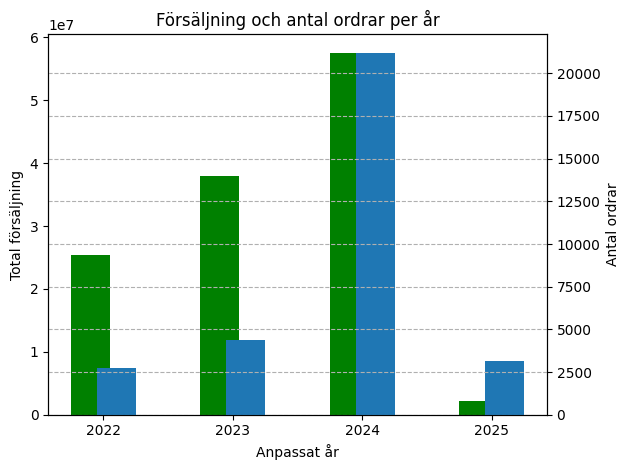

In [29]:
x = np.arange(len(adapt_year_df))

fig, ax = plt.subplots()
ax.bar(x - width/3, adapt_year_df["TotalFörsäljning"], width=0.3, color='green')
ax.set_xlabel("Anpassat år")
ax.set_ylabel("Total försäljning")

ax2 = ax.twinx()
ax2.bar(x + width/3, adapt_year_df["AntalOrdrar"], width=0.3)
ax2.set_ylabel("Antal ordrar")

ax.set_xticks(x)
ax.set_xticklabels(adapt_year_df["AnpassatÅr"])
plt.title("Försäljning och antal ordrar per år")
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--')

In [30]:
max_sales = q5_df.loc[q5_df.TotalFörsäljning.idxmax()]
min_sales = q5_df.loc[q5_df.TotalFörsäljning.idxmin()]
max_orders = q5_df.loc[q5_df.AntalOrdrar.idxmax()]
min_orders = q5_df.loc[q5_df.AntalOrdrar.idxmin()]

print("-------------------------------------")
print(f"""Högst försäljning: {max_sales.TotalFörsäljning.round(0).astype(int)}, år {max_sales.AnpassatÅr.astype(int)}""")
print("-------------------------------------")
print(f"""Lägst försäljning: {min_sales.TotalFörsäljning.round(0).astype(int)}, år {min_sales.AnpassatÅr.astype(int)}""")
print("-------------------------------------")
print(f"""Flest ordrar: {max_orders.AntalOrdrar.astype(int)}, år {max_orders.AnpassatÅr.astype(int)}""")
print("----------------------------")
print(f"""Lägst ordrar: {min_orders.AntalOrdrar.astype(int)}, år {min_orders.AnpassatÅr.astype(int)}""")

-------------------------------------
Högst försäljning: 57587486, år 2024
-------------------------------------
Lägst försäljning: 2160884, år 2025
-------------------------------------
Flest ordrar: 21213, år 2024
----------------------------
Lägst ordrar: 2735, år 2022


Gällande är att år 2025 är ett nyligen påbörjat år, så att lägst försäljning sker där är väntat. Lägst ordrar tillfaller första hela året så det mätvärdet har ökat från start. Slutlig kommentar på försäljning- och ordertrenden är att beroende på hur 2025 fortsätter kan vi se om tillväxten är hållbar eller om nedsaktandet mot slutet av perioden håller i sig.

## 3.5 Uppgift 5

**Vilka 10 produkter genererar mest försäljning?**

In [31]:
#SELECT TOP 5 *
#FROM Production.Product;
#SELECT TOP 5 *
#FROM Sales.SalesOrderDetail

q5 = """
SELECT TOP 8 pp.Name AS Produkt,
        pps.Name AS SubKategori,
        SUM(ssod.LineTotal) AS TotalFörsäljning
FROM Production.Product pp
INNER JOIN Sales.SalesOrderDetail ssod
    ON pp.ProductID = ssod.ProductID
INNER JOIN Production.ProductSubcategory pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
GROUP BY pp.Name, pps.Name
ORDER BY TotalFörsäljning DESC;
"""
q5_df = query_df(q5)
q5_df

,Produkt,SubKategori,TotalFörsäljning
0,"Mountain-200 Black, 38",Mountain Bikes,4.400593e+06
1,"Mountain-200 Black, 42",Mountain Bikes,4.009495e+06
2,"Mountain-200 Silver, 38",Mountain Bikes,3.693678e+06
3,"Mountain-200 Silver, 42",Mountain Bikes,3.438479e+06
4,"Mountain-200 Silver, 46",Mountain Bikes,3.434257e+06
5,"Mountain-200 Black, 46",Mountain Bikes,3.309673e+06
6,"Road-250 Black, 44",Road Bikes,2.516857e+06
7,"Road-250 Black, 48",Road Bikes,2.347656e+06


Produktnamnen anger problematiskt även storlekar på cyklar, och vi går inte in på jämförelse mot produkter som säljs eller avvecklats via SQL's WHERE såsom i *uppgift 2*, så nu testar vi en query som ger topp 10 subkategorier:

In [32]:
q5_sub = """
SELECT TOP 10 pps.Name AS SubKategori,
        SUM(ssod.LineTotal) AS TotalFörsäljning
FROM Production.Product pp
INNER JOIN Sales.SalesOrderDetail ssod
    ON pp.ProductID = ssod.ProductID
INNER JOIN Production.ProductSubcategory pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
GROUP BY pps.Name
ORDER BY TotalFörsäljning DESC;"""

q5_sub_df = query_df(q5_sub)
q5_sub_df

,SubKategori,TotalFörsäljning
0,Road Bikes,4.390944e+07
1,Mountain Bikes,3.644544e+07
2,Touring Bikes,1.429629e+07
3,Mountain Frames,4.713930e+06
4,Road Frames,3.851351e+06
5,Touring Frames,1.642328e+06
6,Jerseys,7.522594e+05
7,Wheels,6.808314e+05
8,Helmets,4.840485e+05
9,Shorts,4.136005e+05


Detta är mera överskådligt men svarar inte riktigt på uppgiften. Notera även att Road Bikes säljer mera som subkategori än Mountain Bikes, medan Mountain Bikes har en sådan produkt som högstsäljande. Därför går vi vidare med string-manipulation i SQL's SELECT (python kan också utgå ifrån q5_df och ordna denna biten men SQL är nu fokus).

In [33]:
q5_string = """
SELECT TOP 10
    LEFT(pp.Name, CHARINDEX(',', pp.Name)-1) AS Produkt,
    pps.Name AS SubKategori,
    SUM(ssod.LineTotal) AS TotalFörsäljning
FROM Production.Product pp
INNER JOIN Sales.SalesOrderDetail ssod
    ON pp.ProductID = ssod.ProductID
INNER JOIN Production.ProductSubcategory pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
WHERE CHARINDEX(',', pp.Name) > 0
GROUP BY LEFT(pp.Name, CHARINDEX(',', pp.Name) - 1), pps.Name
ORDER BY TotalFörsäljning DESC;"""
q5_string_df = query_df(q5_string)
q5_string_df

,Produkt,SubKategori,TotalFörsäljning
0,Mountain-200 Black,Mountain Bikes,1.171976e+07
1,Mountain-200 Silver,Mountain Bikes,1.056641e+07
2,Road-250 Black,Road Bikes,8.383339e+06
3,Road-150 Red,Road Bikes,7.913702e+06
4,Road-250 Red,Road Bikes,5.450657e+06
5,Road-350-W Yellow,Road Bikes,5.246152e+06
6,Mountain-100 Black,Mountain Bikes,5.194848e+06
7,Road-550-W Yellow,Road Bikes,5.183006e+06
8,Touring-1000 Blue,Touring Bikes,5.122950e+06
9,Mountain-100 Silver,Mountain Bikes,4.715231e+06


In [34]:
# Topp produkten och exakt försäljningssiffra, alla storlekar på produkten ihopräknade:
print(q5_string_df.iloc[0])

Produkt             Mountain-200 Black
SubKategori             Mountain Bikes
TotalFörsäljning       11719760.779149
Name: 0, dtype: object


Ovan syns topp-produkten och hur mycket den sålt för (inte storlek för storlek utan totalt). Kategorin är **Bikes**, och den kategorin är alla 10 toppsäljande produkter tillhörande, alltså den fullt dominanta kategorin. Det går att koppla på Production.ProductCategory-tabellen med JOIN för att se kategorinamn, medan sub-kategori valdes att visas i tabellen ovan för presentationsvänlighet.

Text(0.5, 1.0, 'Top 10 produkter efter försäljning')

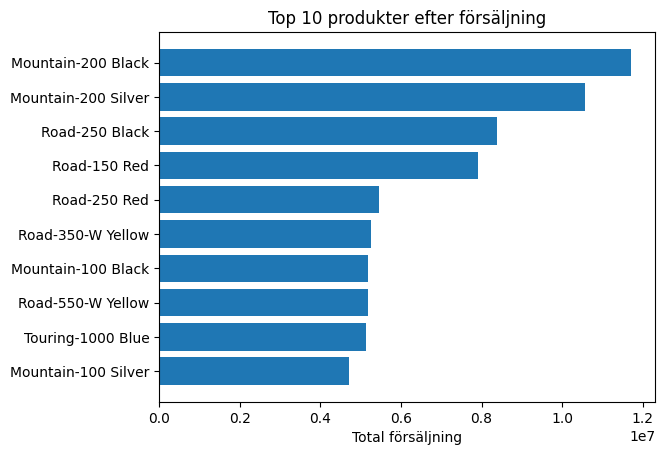

In [35]:
# Som uppgift 4 behöver vi sortera som stigande för barh plot ska ha högst överst.
ascending_df = q5_string_df.copy().sort_values('TotalFörsäljning', ascending=True)

plt.figure()
plt.barh(ascending_df.Produkt, ascending_df.TotalFörsäljning)
plt.xlabel('Total försäljning')
plt.title("Top 10 produkter efter försäljning")

## 3.6 Uppgift 6

**Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?**